<a href="https://colab.research.google.com/github/sayakpaul/A-B-testing-with-Machine-Learning/blob/master/Adversarial_Examples_EfficientNet_NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [ ]:
# TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
# Which GPU?
!nvidia-smi

Thu Sep 24 11:29:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Other imports
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

# Fix the seeds
SEED = 666
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Data collection

In [ ]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

# Specify the class labels, we would need this to create targeted attacks
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


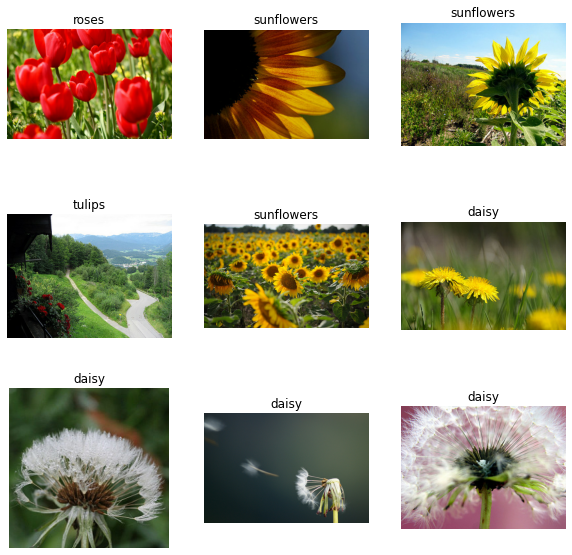

In [ ]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[int(label)])
    plt.axis("off")

## Data preparation

In [ ]:
# Image preprocessing utils

SIZE = (224, 224)

def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, SIZE)
    return (image, label)

In [ ]:
# Construct TensorFlow dataset
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

## Model utilities

In [ ]:
# Reference: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
def get_training_model(base_model):
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate)(x)
    x = Dense(5, activation="softmax")(x)
    classifier = Model(inputs=inputs, outputs=x)
    
    return classifier

def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()

Fetch the noisy student training checkpoints for EfficientNetB0 and convert the checkpoints to `.h5`. 

In [ ]:
!wget -q https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz
!tar -xf noisy_student_efficientnet-b0.tar.gz

In [ ]:
!wget -q https://raw.githubusercontent.com/yixingfu/tensorflow/updateweights/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
!python efficientnet_weight_update_util.py --model b0 --notop --ckpt \
       noisy_student_efficientnet-b0/model.ckpt --o efficientnetb0_notop.h5

## Training an EfficientNetB0 initialized with noisy student training weights

In [ ]:
# Load the EfficientNetB0 model but exclude the classification layers
# Note that the model was trained using noisy student training (https://arxiv.org/abs/1911.04252)
base_model_eb0_nst = EfficientNetB0(weights="efficientnetb0_notop.h5", include_top=False)
base_model_eb0_nst.trainable = False # We are not fine-tuning at this point
get_training_model(base_model_eb0_nst).summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,061,096
Trainable params: 8,965
Non-trainable params: 4,052,131
________________________________________

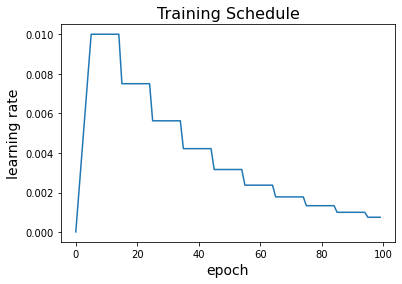

In [ ]:
# CUSTOM LEARNING SCHEUDLE
# Reference: https://www.kaggle.com/cdeotte/how-to-compete-with-gpus-workshop
LR_START = 1e-5
LR_MAX = 1e-2
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)
    return lr
    
lr2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(100)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
49/49 [==============================] - 7s 148ms/step - loss: 1.6134 - accuracy: 0.1827 - val_loss: 1.6389 - val_accuracy: 0.1727

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0020080000000000002.
Epoch 2/30
49/49 [==============================] - 4s 85ms/step - loss: 1.4934 - accuracy: 0.3577 - val_loss: 1.6372 - val_accuracy: 0.1855

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004006.
Epoch 3/30
49/49 [==============================] - 4s 85ms/step - loss: 1.4417 - accuracy: 0.3933 - val_loss: 1.6599 - val_accuracy: 0.1855

Epoch 00004: LearningRateScheduler reducing learning rate to 0.006004000000000001.
Epoch 4/30
49/49 [==============================] - 4s 85ms/step - loss: 1.4107 - accuracy: 0.4157 - val_loss: 1.8253 - val_accuracy: 0.1855

Epoch 00005: LearningRateScheduler reducing learning rate to 0.008002.
Epoch 5/30
49/49 [==============================] - 4

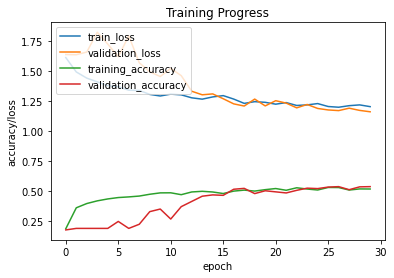

In [ ]:
# Train the model
model_eb0_nst = get_training_model(base_model_eb0_nst)
model_eb0_nst.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
start = time.time()
h = model_eb0_nst.fit(train_ds,
              validation_data=validation_ds,
              epochs=30,
              callbacks=[lr2])
print("Total training time (seconds): ",time.time()-start)
plot_progress(h)

## Training an EfficientNetB0 initialized with ImageNet weights

In [ ]:
# Load the EfficientNetB0 model but exclude the classification layers
# This time the weights are from traditional ImageNet pre-training
base_model_eb0 = EfficientNetB0(weights="imagenet", include_top=False)
base_model_eb0.trainable = False # We are not fine-tuning at this point


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
49/49 [==============================] - 5s 112ms/step - loss: 1.6162 - accuracy: 0.1612 - val_loss: 1.6052 - val_accuracy: 0.2436

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0020080000000000002.
Epoch 2/30
49/49 [==============================] - 4s 86ms/step - loss: 1.4462 - accuracy: 0.3814 - val_loss: 1.9265 - val_accuracy: 0.2436

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004006.
Epoch 3/30
49/49 [==============================] - 4s 85ms/step - loss: 1.3962 - accuracy: 0.4138 - val_loss: 1.8467 - val_accuracy: 0.2436

Epoch 00004: LearningRateScheduler reducing learning rate to 0.006004000000000001.
Epoch 4/30
49/49 [==============================] - 4s 85ms/step - loss: 1.3880 - accuracy: 0.4183 - val_loss: 1.6857 - val_accuracy: 0.2436

Epoch 00005: LearningRateScheduler reducing learning rate to 0.008002.
Epoch 5/30
49/49 [==============================] - 4

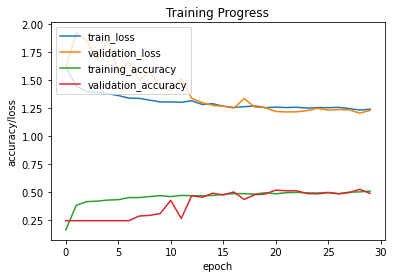

In [ ]:
# Train the model
model_eb0 = get_training_model(base_model_eb0)
model_eb0.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
start = time.time()
h = model_eb0.fit(train_ds,
              validation_data=validation_ds,
              epochs=30,
              callbacks=[lr2])
print("Total training time (seconds): ",time.time()-start)
plot_progress(h)

## Plotting sample predictions

In [ ]:
# Utility to plot sample predictions 
def plot_predictions(images, labels, probability):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        predicted_label = CLASSES[np.argmax(probability[i])]
        maximum_probability = "{:.3f}".format(max(probability[i]))
        text = "{} with probability: {}".format(predicted_label, maximum_probability) + \
            "\nGround-truth: {}".format(CLASSES[int(labels[i])])
        plt.title(text)
        plt.axis("off")
    plt.show()

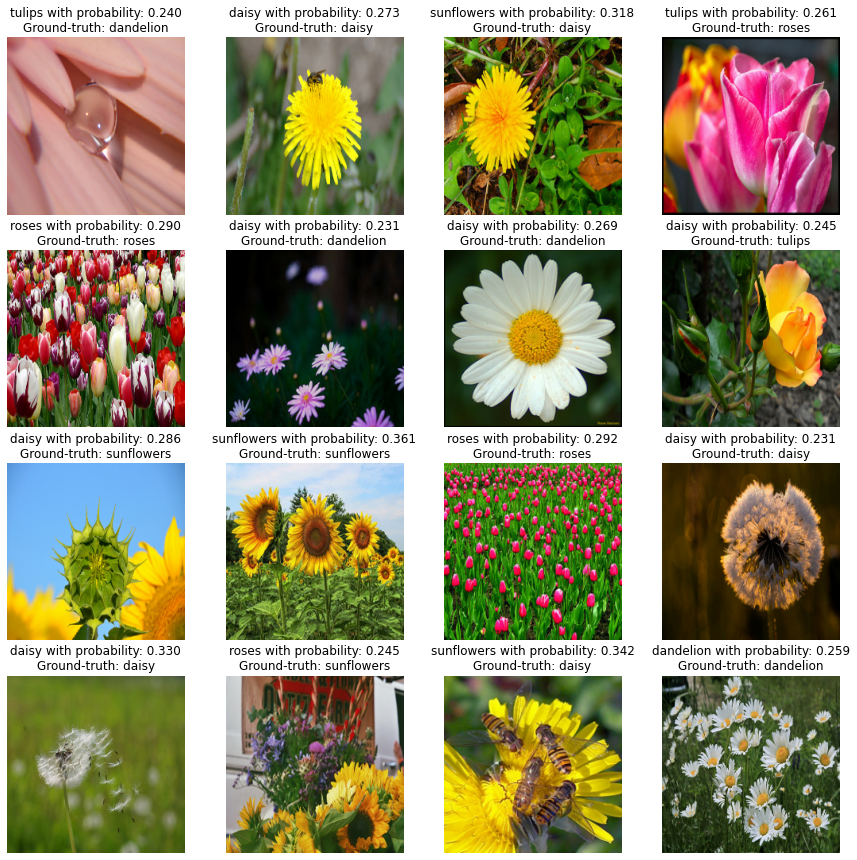

In [ ]:
# Let's run inference on a batch of images from the validation set
(batch_images, batch_labels) = next(iter(validation_ds))
predictions = tf.nn.softmax(model_eb0.predict(batch_images))
plot_predictions(batch_images[:16], batch_labels[:16], predictions[:16])

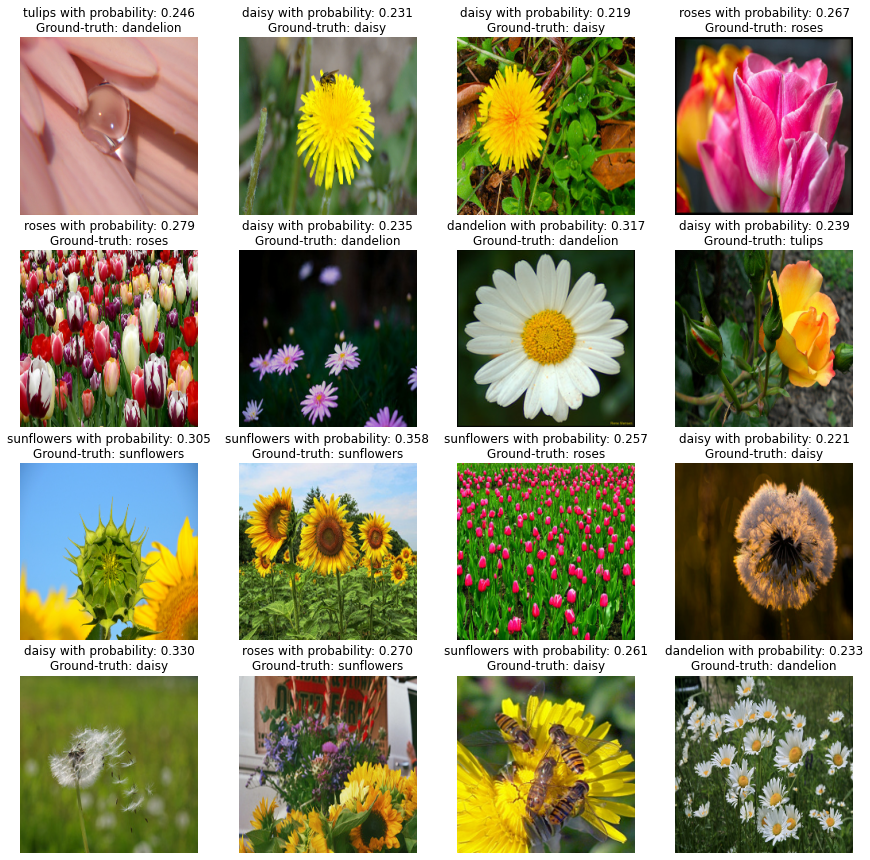

In [ ]:
# Let's run inference on a batch of images from the validation set
(batch_images, batch_labels) = next(iter(validation_ds))
predictions = tf.nn.softmax(model_eb0_nst.predict(batch_images))
plot_predictions(batch_images[:16], batch_labels[:16], predictions[:16])

## Utilities for creating a targeted adversarial example

In [ ]:
#@title
# Clipping utility so that the pixel values stay within [0,1]
EPS = 2./255

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

In [ ]:
#@title
def generate_adversaries_targeted(model, image_tensor, delta, 
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = (image_tensor + delta)/255.
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

In [ ]:
#@title
def perturb_image(model, image, true, target):
    print("Before adversarial attack")
    preprocessed_image = image/255.
    probabilities = tf.nn.softmax(model.predict(preprocessed_image))
    class_index = np.argmax(probabilities)
    print("Ground-truth label: {} predicted label: {}".format(CLASSES[true], CLASSES[class_index]))
    
    # Initialize the perturbation quantity
    image_tensor = tf.constant(image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries_targeted(model, image_tensor, delta, true, target)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = (image_tensor + delta_tensor)/255.
    print("After adversarial attack")
    
    # Generate predictions
    preds = model.predict(perturbed_image)[0]
    i = np.argmax(preds)
    pred_label = CLASSES[i]

    print("Predicted label: {}".format(pred_label))
    cv2.imwrite("perturbed_image.png", perturbed_image.numpy().squeeze())

Turning a dandelion (last image from the figure above) to a tulip. 

In [ ]:
# Pick an image from the validation set
index = 15
sample_val_image = (batch_images[index].numpy()*255).astype(np.uint8)
sample_val_image = np.expand_dims(sample_val_image, 0)

Before adversarial attack
Ground-truth label: dandelion predicted label: dandelion
0 0.40929508
20 0.3898461
40 0.36815083
60 0.3461535
80 0.32398355
100 0.30183518
120 0.2799641
140 0.2584114
160 0.23727012
180 0.21664214
200 0.1966312
220 0.17733884
240 0.15880668
260 0.14102209
280 0.124038815
300 0.107843876
320 0.09253824
340 0.07794571


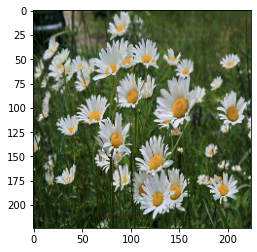

After adversarial attack
Predicted label: roses


In [ ]:
#@title EfficientNetB0 with ImageNet initialization
# Tulips class index 4
perturb_image(model_eb0, sample_val_image, batch_labels[index].numpy(), 4)

Before adversarial attack
Ground-truth label: dandelion predicted label: dandelion
0 0.23893929
20 0.2171967
40 0.19341719
60 0.16986918
80 0.14675105
100 0.12457991
120 0.10325897
140 0.08294332
180 0.045601368
200 0.028640509
220 0.012902141
240 -0.0017027855
260 -0.015228391
280 -0.027688622
300 -0.039161086
320 -0.049697995
340 -0.05942297


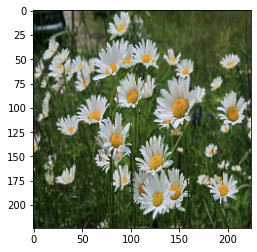

After adversarial attack
Predicted label: roses


In [ ]:
#@title EfficientNetB0 with noisy student training initialization
perturb_image(model_eb0_nst, sample_val_image, batch_labels[index].numpy(), 4)